In [1]:
!pip install timm==0.9.2 torch torchvision pandas scikit-learn matplotlib xgboost easyocr --quiet seaborn




[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [2]:
import os
import pandas as pd
import numpy as np
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import timm
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import string
import xgboost as xgb

import easyocr


/Users/manshusainishab/Library/Python/3.11/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import os
import pandas as pd

# Set your local paths here (CHANGE these to your real paths)
BASE_PATH = "/Users/manshusainishab/Desktop/dataset/train"     # example path
CSV_PATH_VIT = "/Users/manshusainishab/Desktop/dataset/images_numeric_labels.csv"
CSV_PATH_OCR = "/Users/manshusainishab/Desktop/dataset/images_numeric_labels2.csv"


IMAGE_DIR = BASE_PATH

# Load dataframe
df = pd.read_csv(CSV_PATH_VIT)
df2 = pd.read_csv(CSV_PATH_OCR)


# Keep only filename (remove full path)
df['image_path'] = df['image_path'].apply(os.path.basename)
df2['image_path'] = df2['image_path'].apply(os.path.basename)


print("Total samples:", len(df))
# df.head()
# df2.head()


Total samples: 301


In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

class AadhaarDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = os.path.join(self.img_dir, row['image_path'])
        image = Image.open(path).convert("RGB")
        label = torch.tensor(row['label'], dtype=torch.long)
        if self.transform:
            image = self.transform(image)
        return image, label, row['image_path']


In [5]:
dataset = AadhaarDataset(df, IMAGE_DIR, transform) 
train_size = int(0.8 * len(dataset)) 
test_size = len(dataset) - train_size 
train_dataset, test_dataset = random_split(dataset, [train_size, test_size]) 
train_indices = train_dataset.indices 
test_indices = test_dataset.indices 
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True) 
test_loader = DataLoader(test_dataset, batch_size=8) 
print(len(train_dataset), len(test_dataset))

240 61


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = timm.create_model('vit_base_patch16_224', pretrained=True)
num_ftrs = model.head.in_features
model.head = nn.Linear(num_ftrs, 1)

model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [7]:
def train_model(model, loader, criterion, optim, device):
    model.train()
    total, correct, loss_sum = 0, 0, 0

    for imgs, labels, _ in loader:
        imgs, labels = imgs.to(device), labels.float().unsqueeze(1).to(device)

        optim.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optim.step()

        preds = (torch.sigmoid(outputs) >= 0.5).float()
        correct += (preds == labels).sum().item()
        total += len(labels)
        loss_sum += loss.item() * len(labels)

    return loss_sum/total, correct/total

def eval_model(model, loader, criterion, device):
    model.eval()
    total, correct, loss_sum = 0, 0, 0
    preds_all, labels_all = [], []

    with torch.no_grad():
        for imgs, labels, _ in loader:
            imgs, labels = imgs.to(device), labels.float().unsqueeze(1).to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss_sum += loss.item()*len(labels)

            preds = (torch.sigmoid(outputs) >= 0.5).float()

            correct += (preds == labels).sum().item()
            total += len(labels)

            preds_all.extend(preds.cpu().numpy().flatten())
            labels_all.extend(labels.cpu().numpy().flatten())

    return loss_sum/total, correct/total, preds_all, labels_all


In [8]:
for epoch in range(10):
    tl, ta = train_model(model, train_loader, criterion, optimizer, device)
    vl, va, _, _ = eval_model(model, test_loader, criterion, device)
    print(f"Epoch {epoch+1} | Train Acc: {ta:.4f} | Test Acc: {va:.4f}")


Epoch 1 | Train Acc: 0.6750 | Test Acc: 0.8361
Epoch 2 | Train Acc: 0.8458 | Test Acc: 0.9180
Epoch 3 | Train Acc: 0.9208 | Test Acc: 1.0000
Epoch 4 | Train Acc: 0.9167 | Test Acc: 0.9836
Epoch 5 | Train Acc: 0.9208 | Test Acc: 0.9016
Epoch 6 | Train Acc: 0.9542 | Test Acc: 0.9508
Epoch 7 | Train Acc: 0.9625 | Test Acc: 0.9508
Epoch 8 | Train Acc: 0.9625 | Test Acc: 0.9508
Epoch 9 | Train Acc: 0.9417 | Test Acc: 0.9672
Epoch 10 | Train Acc: 0.9542 | Test Acc: 0.9836



Confusion Matrix:
[[39  1]
 [ 0 21]]


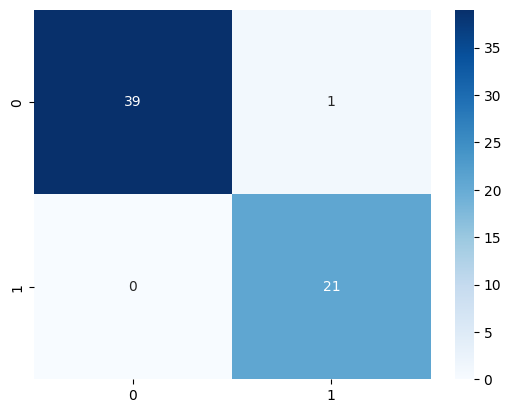

In [9]:
test_loss, test_acc, preds, labels = eval_model(model, test_loader, criterion, device)

print("\nConfusion Matrix:")
cm = confusion_matrix(labels, preds)
print(cm)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.show()


In [10]:
print("Stage 2 check")

Stage 2 check


In [11]:
!pip install sentence-transformers --quiet
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"


import ssl
ssl._create_default_https_context = ssl._create_unverified_context




[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [12]:
import pytesseract
from PIL import Image

TESS_LANGS = "eng+hin+tam+tel+kan+mal+ben+mar+pan+guj"

def extract_text(path):
    text = pytesseract.image_to_string(
        Image.open(path),
        lang=TESS_LANGS
    )
    return text.strip()


In [13]:
import re
import unicodedata

INDIAN_SCRIPTS = {
    "devanagari",  # hi, mr, ne, sa, bho, mai
    "bengali",     # bn, as, mni
    "tamil",       # ta
    "telugu",      # te
    "kannada",     # kn
    "malayalam",   # ml (your model doesn't support OCR for it)
    "oriya",       # odia (not supported in EasyOCR)
    "gurmukhi",    # Punjabi (not supported)
}

LATIN = "latin"

def detect_script_counts(text):
    counts = {
        "latin": 0,
        "devanagari": 0,
        "bengali": 0,
        "tamil": 0,
        "telugu": 0,
        "kannada": 0,
        "malayalam": 0,
        "oriya": 0,
        "gurmukhi": 0,
        "arabic": 0,
        "other": 0
    }

    for ch in text:
        if ch.isspace() or ch.isdigit():
            continue

        try:
            block = unicodedata.name(ch)
        except:
            counts["other"] += 1
            continue

        if "DEVANAGARI" in block:
            counts["devanagari"] += 1
        elif "BENGALI" in block:
            counts["bengali"] += 1
        elif "TAMIL" in block:
            counts["tamil"] += 1
        elif "TELUGU" in block:
            counts["telugu"] += 1
        elif "KANNADA" in block:
            counts["kannada"] += 1
        elif "MALAYALAM" in block:
            counts["malayalam"] += 1
        elif "ORIYA" in block or "ODIA" in block:
            counts["oriya"] += 1
        elif "GURMUKHI" in block:
            counts["gurmukhi"] += 1
        elif "LATIN" in block:
            counts["latin"] += 1
        elif "ARABIC" in block:
            counts["arabic"] += 1
        else:
            counts["other"] += 1

    return counts


In [14]:
NOISE_LIMIT = 5

def major_scripts(counts):
    # Only keep scripts with >= 5 characters
    return {script for script, c in counts.items() if c >= NOISE_LIMIT}


In [15]:
def allowed_mix_with_noise(counts):
    scripts = major_scripts(counts)

    # If only English
    if scripts == {"latin", "other"}:
        return True

    # Only Hindi
    if scripts == {"devanagari", "other"}:
        return True

    # English + Hindi only
    if scripts == {"latin", "devanagari", "other"}:
        return True

    # Anything else → reject
    return False


In [16]:
from sentence_transformers import SentenceTransformer
embedder = SentenceTransformer("all-mpnet-base-v2")

def text_embedding(text):
    vector = embedder.encode(text)
    return vector


In [19]:
X_vectors = []
y_labels = []

print("Extracting OCR + embeddings for all images...")


import warnings

# Ignore specific user warnings
warnings.filterwarnings("ignore", message="'pin_memory' argument is set as true but not supported on MPS now")

for i, row in df2.iterrows():
    path = os.path.join(IMAGE_DIR, row["image_path"])
    text = extract_text(path)
    emb = text_embedding(text)     # 384-d vector
    X_vectors.append(emb)
    y_labels.append(row["label"])

X_vectors = np.vstack(X_vectors)
y_labels = np.array(y_labels)

print("Embedding matrix shape:", X_vectors.shape)



Extracting OCR + embeddings for all images...
Embedding matrix shape: (301, 768)


In [20]:
train_mask = np.zeros(len(df), dtype=bool)
test_mask = np.zeros(len(df), dtype=bool)
train_mask[train_indices] = True
test_mask[test_indices] = True

X_train = X_vectors[train_mask]
X_test = X_vectors[test_mask]
y_train = y_labels[train_mask]
y_test = y_labels[test_mask]

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (240, 768) Test: (61, 768)


In [23]:

xgb_model = xgb.XGBClassifier(
    max_depth=6,
    n_estimators=300,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="binary:logistic"
)

xgb_model.fit(X_train, y_train)

def predict_pipeline(path):
    # ---------- Stage 1: ViT ----------
    img = Image.open(path).convert("RGB")
    img_t = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        out = torch.sigmoid(model(img_t)).item()
        vit_pred = 1 if out >= 0.65 else 0

    # If ViT rejects → stop here
    if vit_pred == 0:
        return {
            "final": 0,
            "reason": "ViT rejected (Stage 1)",
            "stage1_vit": vit_pred,
            "stage2_xgb": None,
            "ocr_text": None,
        }

    # ---------- Stage 2: OCR + Embedding + XGBoost ----------
    # ---------------- Stage 2: OCR + Language Filter + Embedding + XGB ----------------

    text = extract_text(path)
    counts = detect_script_counts(text)

    if not allowed_mix_with_noise(counts):
        return {
            "final": 0,
            "reason": f"Rejected: script frequencies {counts}",
            "stage1_vit": vit_pred,
            "stage2_xgb": None,
            "ocr_text": text
        }


    # 2️⃣ Continue with your embedding + XGB
    emb = text_embedding(text).reshape(1, -1)
    
    xgb_pred = int(xgb_model.predict(emb)[0])
    prob = float(xgb_model.predict_proba(emb)[0, 1])
    
    return {
        "stage1_vit": vit_pred,
        "stage2_xgb": xgb_pred,
        "xgb_prob": prob,
        "ocr_text": text,
        "script_detected": counts.items(),
        "final": xgb_pred}



In [24]:
sample = "/Users/manshusainishab/Desktop/dataset/train/adhar_c25.jpg"
result = predict_pipeline(sample)
result


{'stage1_vit': 1,
 'stage2_xgb': 1,
 'xgb_prob': 0.9864479303359985,
 'ocr_text': 'नाम / Name:\nFatima ahmed\n\nजन्म तारीख / DOB: 03-02-1994\nFemale ನ\n\n9876 5432 1130\nआधार - आदमी का अधकिर',
 'script_detected': dict_items([('latin', 24), ('devanagari', 27), ('bengali', 0), ('tamil', 0), ('telugu', 0), ('kannada', 1), ('malayalam', 0), ('oriya', 0), ('gurmukhi', 0), ('arabic', 0), ('other', 7)]),
 'final': 1}

In [25]:
sample = "/Users/manshusainishab/Downloads/image_128.png"
result = predict_pipeline(sample)
result


{'final': 0,
 'reason': 'ViT rejected (Stage 1)',
 'stage1_vit': 0,
 'stage2_xgb': None,
 'ocr_text': None}

Evaluating full pipeline (Stage1 + Stage2)...

📘 Classification Report (Final Output)
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        46
           1       1.00      0.93      0.97        15

    accuracy                           0.98        61
   macro avg       0.99      0.97      0.98        61
weighted avg       0.98      0.98      0.98        61


📊 Confusion Matrix (Final):
[[46  0]
 [ 1 14]]


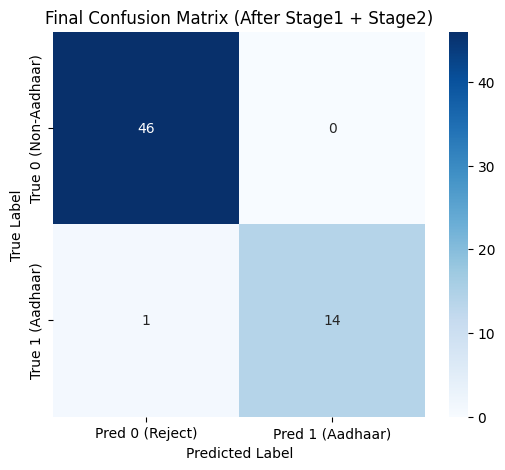

In [26]:
final_preds = []
final_labels = []

print("Evaluating full pipeline (Stage1 + Stage2)...")

for idx in test_indices:
    row = df2.iloc[idx]
    path = os.path.join(IMAGE_DIR, row["image_path"])
    true_label = row["label"]

    result = predict_pipeline(path)
    final_pred = result["final"]

    final_labels.append(true_label)
    final_preds.append(final_pred)

# Convert to numpy arrays
final_labels = np.array(final_labels)
final_preds = np.array(final_preds)

# Print classification report
print("\n📘 Classification Report (Final Output)")
print(classification_report(final_labels, final_preds))

# Confusion matrix
cm = confusion_matrix(final_labels, final_preds)
print("\n📊 Confusion Matrix (Final):")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred 0 (Reject)', 'Pred 1 (Aadhaar)'],
            yticklabels=['True 0 (Non-Aadhaar)', 'True 1 (Aadhaar)'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Final Confusion Matrix (After Stage1 + Stage2)")
plt.show()


In [27]:
torch.save(model.state_dict(), "/Users/manshusainishab/Desktop/AIML model/vit.pth")

# xgb_model.save_model("/Users/manshusainishab/Desktop/AIML model/xgb_model.model")


/Users/manshusainishab/Library/Python/3.11/lib/python/site-packages/xgboost/sklearn.py:1116: UserWarning: [13:08:14] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1575: Saving model in the UBJSON format as default.  You can use a file extension: `json` or `ubj` to choose between formats.
  self.get_booster().save_model(fname)


In [28]:
xgb_model.save_model("/Users/manshusainishab/Desktop/AIML model/xgb_model.json")


# Importing the weights to the VIT model (Inference model(ViT, Xg_boost))

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = timm.create_model('vit_base_patch16_224', pretrained=False)
num_ftrs = model.head.in_features
model.head = nn.Linear(num_ftrs, 1)

model.load_state_dict(torch.load(
    "/Users/manshusainishab/Desktop/AIML model/vit_weights.pth",
    map_location=device
))


<All keys matched successfully>

In [30]:
model = model.to(device)
model.eval()


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [31]:
xgb_model.load_model("/Users/manshusainishab/Desktop/AIML model/xgb_model_weights.json")

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [33]:
sample = "/Users/manshusainishab/Desktop/dataset/train/adhar_c25.jpg"
result = predict_pipeline(sample)
result


{'stage1_vit': 1,
 'stage2_xgb': 1,
 'xgb_prob': 0.9864479303359985,
 'ocr_text': 'नाम / Name:\nFatima ahmed\n\nजन्म तारीख / DOB: 03-02-1994\nFemale ನ\n\n9876 5432 1130\nआधार - आदमी का अधकिर',
 'script_detected': dict_items([('latin', 24), ('devanagari', 27), ('bengali', 0), ('tamil', 0), ('telugu', 0), ('kannada', 1), ('malayalam', 0), ('oriya', 0), ('gurmukhi', 0), ('arabic', 0), ('other', 7)]),
 'final': 1}